In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from IPython.core.debugger import set_trace
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
summary_data = pd.read_csv('massey_seasons_with_id.csv')
summary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 13 columns):
SAG          5454 non-null int64
WLK          5454 non-null float64
WOL          5454 non-null int64
Team         5454 non-null object
RTH          5454 non-null int64
COL          5454 non-null float64
POM          5454 non-null float64
DOL          5454 non-null float64
RPI          5454 non-null float64
MOR          5454 non-null int64
season       5454 non-null int64
win_pct      5454 non-null float64
kaggle_id    5454 non-null object
dtypes: float64(6), int64(5), object(2)
memory usage: 554.0+ KB


In [3]:
summary_data.describe()

,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR,season,win_pct
count,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000,5454.000000
mean,171.387055,171.340484,171.412725,171.364503,171.321782,171.310231,171.341217,171.283645,171.301247,2010.621746,0.513328
std,98.977414,98.926046,98.995735,98.973345,98.887448,98.906044,98.922645,98.868126,98.914325,4.595077,0.179117
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2003.000000,0.000000
25%,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,2007.000000,0.387097
50%,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,2011.000000,0.515152
75%,257.000000,257.000000,257.000000,257.000000,256.750000,257.000000,257.000000,256.000000,257.000000,2015.000000,0.645161
max,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,2018.000000,1.000000


In [4]:
summary_data = summary_data[summary_data['season'] < 2018]
summary_data.describe()['season']

count    5103.000000
mean     2010.114247
std         4.308661
min      2003.000000
25%      2006.000000
50%      2010.000000
75%      2014.000000
max      2017.000000
Name: season, dtype: float64

In [5]:
summary_data[summary_data.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [6]:
#summary_data[summary_data['season']==2013][['Team','SAG']].sort_values(by=['SAG'])

In [7]:
tourney_data = pd.read_csv('tournament_results.csv')
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [8]:
tourney_data[tourney_data.isnull().any(axis=1)]

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id


In [9]:
tourney_data = tourney_data[tourney_data['season'] >= 2003]
tourney_data.describe()['season']

count     981.000000
mean     2010.085627
std         4.325153
min      2003.000000
25%      2006.000000
50%      2010.000000
75%      2014.000000
max      2017.000000
Name: season, dtype: float64

In [10]:
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,1,2010
32,2007,64,2007-03-15,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,1,2006
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,1,2010


In [11]:
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id','start_season'],inplace=True)
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0


In [12]:

m_tourney_data = tourney_data.merge(summary_data, left_on=['season','team_id'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

m_tourney_data.head()

#m_tourney_data.drop(columns=['season_y','kaggle_id'],inplace=True)


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,win_pct,kaggle_id
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,25,27.0,36,NC State,28,32.0,35.0,32.0,33.0,24,0.705882,52df1e19-b142-4a76-a439-ad68455d0581
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,32,30.0,25,Temple,32,27.0,38.0,25.0,30.0,45,0.781250,8598d1b6-106b-4083-a512-2e495729525a
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,62,55.0,52,Akron,59,50.0,54.0,46.0,42.0,60,0.812500,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,50,43.0,32,VA Commonwealth,54,35.0,47.0,33.0,38.0,55,0.823529,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2,2.0,3,Kansas,2,1.0,3.0,2.0,1.0,3,0.942857,fae4855b-1b64-4b40-a632-9ed345e1e952


In [13]:
#m_tourney_data.head()
m_tourney_data[m_tourney_data.isnull().any(axis=1)]

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,win_pct,kaggle_id


In [14]:
tourney_data = m_tourney_data.merge(summary_data, left_on=['season','opp_team_id'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

In [15]:
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,SAG_t,WLK_t,WOL_t,Team_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,win_pct_t,kaggle_id_t,SAG_o,WLK_o,WOL_o,Team_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,win_pct_o,kaggle_id_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,25,27.0,36,NC State,28,32.0,35.0,32.0,33.0,24,0.705882,52df1e19-b142-4a76-a439-ad68455d0581,55,58.0,35,Temple,47,40.0,68.0,45.0,41.0,52,0.718750,8598d1b6-106b-4083-a512-2e495729525a
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,32,30.0,25,Temple,32,27.0,38.0,25.0,30.0,45,0.781250,8598d1b6-106b-4083-a512-2e495729525a,45,42.0,43,Penn St,37,39.0,39.0,39.0,39.0,27,0.575758,4aebd148-8119-4875-954c-66779867989b
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,62,55.0,52,Akron,59,50.0,54.0,46.0,42.0,60,0.812500,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,26,19.0,27,VA Commonwealth,27,27.0,21.0,31.0,24.0,16,0.764706,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,50,43.0,32,VA Commonwealth,54,35.0,47.0,33.0,38.0,55,0.823529,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,10.0,16,Wichita St,16,11.0,10.0,15.0,12.0,10,0.843750,f38b58de-3273-4723-a78b-2f918e9aa2d5
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2,2.0,3,Kansas,2,1.0,3.0,2.0,1.0,3,0.942857,fae4855b-1b64-4b40-a632-9ed345e1e952,77,55.0,54,VA Commonwealth,74,59.0,84.0,72.0,49.0,80,0.676471,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518


In [16]:
tourney_data.rename(index=str,columns={'team_seed':'seed_t', 'opp_team_seed':'seed_o'},inplace=True)

In [17]:
tourney_data.drop(columns=['Team_t','Team_o','kaggle_id_o','kaggle_id_t'],inplace=True)
tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,game_result,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,win_pct_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,win_pct_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,25,27.0,36,28,32.0,35.0,32.0,33.0,24,0.705882,55,58.0,35,47,40.0,68.0,45.0,41.0,52,0.718750
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,32,30.0,25,32,27.0,38.0,25.0,30.0,45,0.781250,45,42.0,43,37,39.0,39.0,39.0,39.0,27,0.575758
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,62,55.0,52,59,50.0,54.0,46.0,42.0,60,0.812500,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0.764706
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,50,43.0,32,54,35.0,47.0,33.0,38.0,55,0.823529,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0.843750
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2,2.0,3,2,1.0,3.0,2.0,1.0,3,0.942857,77,55.0,54,74,59.0,84.0,72.0,49.0,80,0.676471


####  Upsets


In [18]:
tournament_games = {}
for year in range(2003,2018,1):
    tournament_games[year] = tourney_data[tourney_data['season'] == year].shape[0]

In [19]:

def compute_percentage(x):
    #print(x)
    game_count = tournament_games[x[0]]
    #set_trace()
    val = 100.0 * len(x)/ game_count
    
    return val


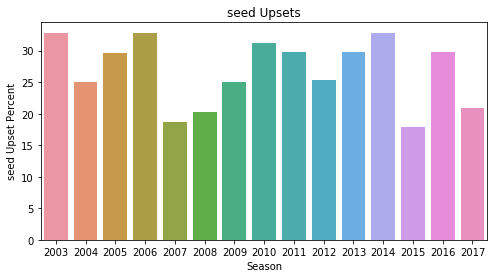

Average seed upsets per tournament season=  17.533333333333335


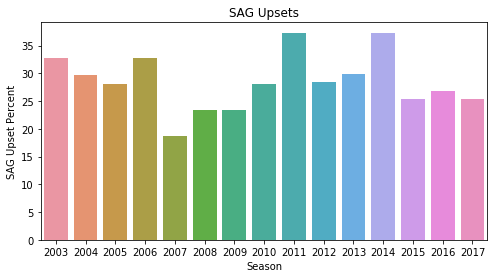

Average SAG upsets per tournament season=  18.666666666666668


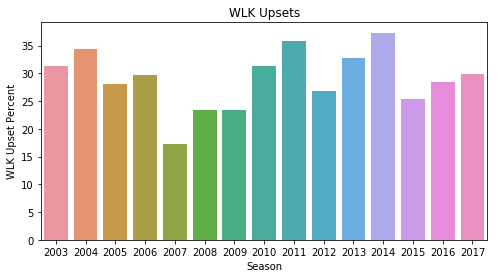

Average WLK upsets per tournament season=  19.0


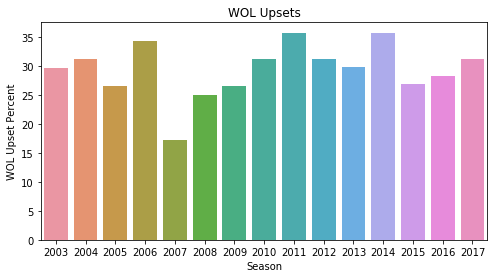

Average WOL upsets per tournament season=  19.266666666666666


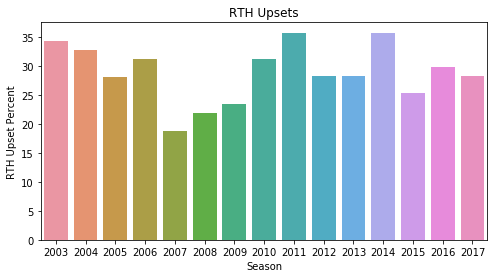

Average RTH upsets per tournament season=  18.933333333333334


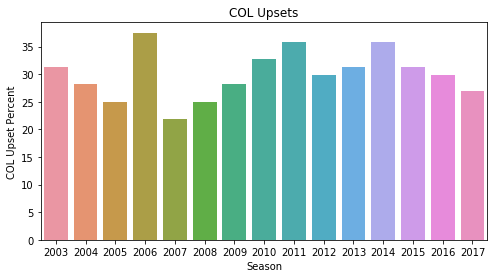

Average COL upsets per tournament season=  19.666666666666668


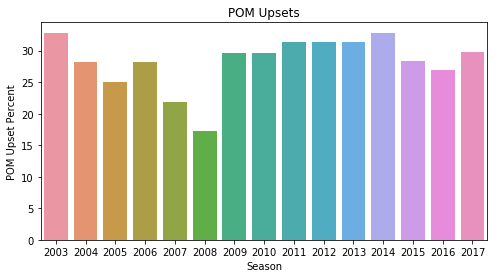

Average POM upsets per tournament season=  18.533333333333335


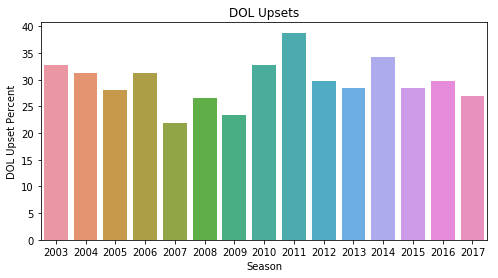

Average DOL upsets per tournament season=  19.4


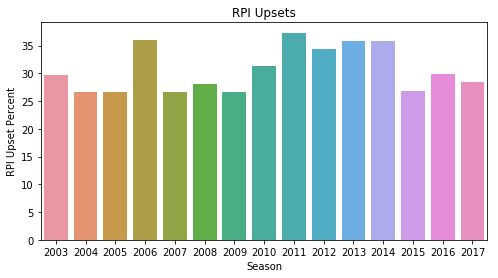

Average RPI upsets per tournament season=  20.066666666666666


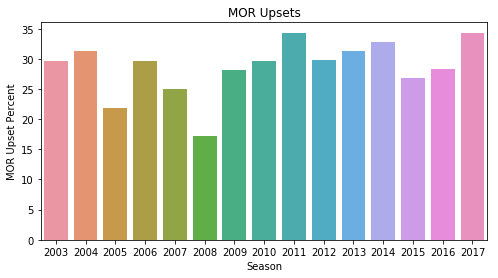

Average MOR upsets per tournament season=  18.8


In [20]:
ratings_dict={}
ratings = ['seed','SAG','WLK','WOL','RTH','COL','POM','DOL','RPI','MOR']
for rating in ratings:
    rating_t = rating + '_t'
    rating_o = rating + '_o'
    upset_cond_1 = (tourney_data['game_result']==0) & (tourney_data[rating_t] < tourney_data[rating_o] )
    upset_cond_2 = (tourney_data['game_result']==1) & (tourney_data[rating_t] > tourney_data[rating_o] )
    upsets = tourney_data[upset_cond_1 | upset_cond_2][['season','round', 'team','opp_team','game_result',rating_t,rating_o ]]
    plot = sns.barplot(x='season', y='season',data=upsets, orient='v',estimator=lambda x: compute_percentage(x))
    plot.set(xlabel='Season', ylabel=rating +' Upset Percent')
    plot.set_title(rating + " Upsets")
    plot.figure.set_size_inches(8,4)
    plt.show()
    avg_upsets = upsets.shape[0]/upsets['season'].nunique()
    print("Average " + rating + " upsets per tournament season= ",avg_upsets)
    ratings_dict[rating] = avg_upsets


In [21]:
sorted_ratings = sorted(ratings_dict.items(), key=operator.itemgetter(1))

sorted_ratings


[('seed', 17.533333333333335),
 ('POM', 18.533333333333335),
 ('SAG', 18.666666666666668),
 ('MOR', 18.8),
 ('RTH', 18.933333333333334),
 ('WLK', 19.0),
 ('WOL', 19.266666666666666),
 ('DOL', 19.4),
 ('COL', 19.666666666666668),
 ('RPI', 20.066666666666666)]

Text(0,0.5,'Upsets')

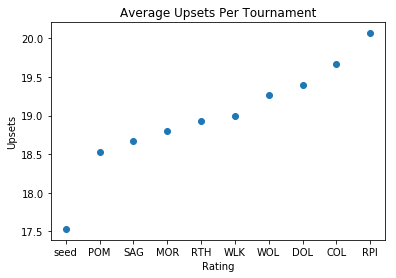

In [22]:
plt.scatter(*zip(*sorted_ratings))
plt.title('Average Upsets Per Tournament')
plt.xlabel('Rating')
plt.ylabel('Upsets')